In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    rmse,
    mae,
    logloss,
    rsquared,
    exp_var,
    auc,
    confusion_matrix
)
from recommenders.utils.timer import Timer
from sklearn.preprocessing import minmax_scale
from recommenders.utils.python_utils import binarize
from recommenders.utils.plot import line_graph

In [2]:
def load_df(size="1"):
  if(size==5):
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_1.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
    for i in range(2,5):
      df_temp = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{i}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
      df.append(df_temp)
  else:
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{size}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
  df.index = np.arange(0,len(df))
  df_nan = pd.DataFrame(pd.isnull(df.rating))
  df_nan = df_nan[df_nan['rating'] == True]
  df_nan = df_nan.reset_index()
  movie_np = []
  movie_id = 1
  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)
  df = df[pd.notnull(df['rating'])]
  df['itemID'] = movie_np.astype(int)
  df['userID'] = df['userID'].astype(int)
  df['rating'] = df['rating'].astype(float)
  df = df[df["itemID"]<=1500]
  df = df[df["userID"]<=50000]
  return df

In [3]:
df = load_df()

In [4]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df = df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

In [5]:
Xtr, Xtst = numpy_stratified_split(X)

In [6]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (8169, 1446)
test matrix size (8169, 1446)


In [7]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Took 36.18 seconds for training.


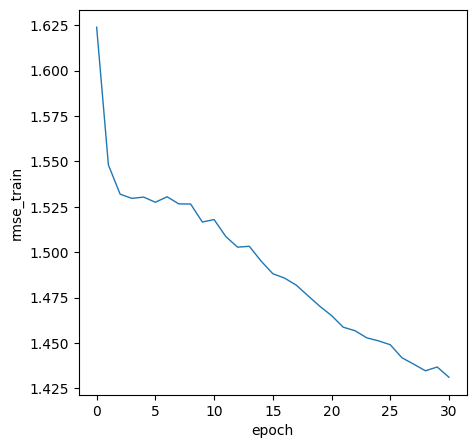

In [8]:
# Model Fit
with Timer() as train_time:
    model.fit(Xtr)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [9]:
# number of top score elements to be recommended  
K = 10

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k =  model.recommend_k_items(Xtst)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 0.93 seconds for prediction.


In [10]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [11]:
top_k_df.head(10)

,userID,itemID,prediction
0,6,1467,4.764702
1,6,1220,4.586649
2,6,781,4.741897
3,6,59,4.769601
4,6,14,4.727356
5,6,1327,4.463492
6,6,392,4.532022
7,6,1380,4.914730
8,6,1398,4.471320
9,6,1159,4.835432


In [12]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating', k=K)
    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating', k=K)
    eval_precision = precision_at_k(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating', k=K)
    eval_recall = recall_at_k(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating', k=K)
    eval_rmse = rmse(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating')
    eval_mae = mae(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating')
    eval_rsquared = rsquared(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating')
    eval_exp_var = exp_var(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating')
#     eval_auc = auc(data_true, data_pred, col_user='userID', col_item='itemID', col_rating='rating')

    positivity_threshold = 2
    test_bin = data_true.copy()
    test_bin['rating'] = binarize(test_bin['rating'], positivity_threshold)

    top_k_prob = data_pred.copy()
    top_k_prob['prediction'] = minmax_scale(
        top_k_prob['prediction'].astype(float)
    )
    
    eval_logloss = logloss(test_bin, top_k_prob, col_user='userID', col_item='itemID', col_rating='rating')
    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "RMSE": eval_rmse,
            "MAE" : eval_mae,
            "Rsquared" : eval_rsquared,
            "Exp_Var" : eval_exp_var,
            "logloss" : eval_logloss
        }, 
        index=[0]
    )
    
    return df_result

In [13]:
eval_100k = ranking_metrics(
    data_size="netflix 100k",
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,RMSE,MAE,Rsquared,Exp_Var,logloss
0,netflix 100k,10,0.107067,0.215959,0.126111,0.316913,0.693523,0.547062,-0.01236,0.087436,0.338721


In [6]:
conf_mat = confusion_matrix(model,test,"RBM")

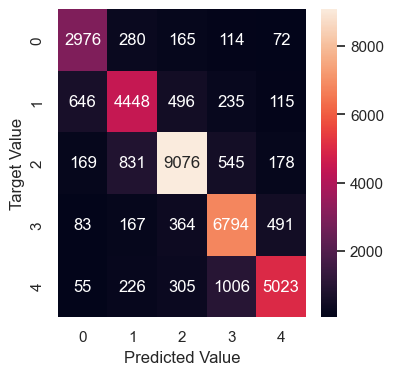

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(conf_mat,fmt='',annot=True)
plt.xlabel("Predicted Value")
plt.ylabel("Target Value")
plt.show()

In [14]:
model.save(file_path='./models/rbm_model.ckpt')